# Modelagem de CNN - Câncer de Mama (CBIS-DDSM)

Este notebook implementa e treina modelos de Redes Neurais Convolucionais (CNNs) para classificação de câncer de mama em imagens de mamografia.

## Metodologia

- **Pré-processamento**: Redimensionamento, normalização, conversão para escala de cinza, data augmentation
- **Divisão dos Dados**: 60% treino / 20% validação / 20% teste
- **Modelos**: CNN construída do zero (adaptada para imagens em escala de cinza)
- **Avaliação**: Accuracy, Precision, Recall, F1-Score, ROC-AUC
- **Interpretabilidade**: Grad-CAM para visualizar regiões importantes


In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import tensorflow as tf
from tensorflow import keras
import importlib
from sklearn.model_selection import train_test_split

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

# Importar e recarregar módulos do projeto (para garantir que estamos usando a versão mais recente)
# IMPORTANTE: Se você ainda tiver erros, reinicie o kernel (Kernel -> Restart Kernel)
import src.vision.data_loader
import src.vision.evaluation
importlib.reload(src.vision.data_loader)
importlib.reload(src.vision.evaluation)

# Verificar se o módulo foi recarregado corretamente
import inspect
grad_cam_source = inspect.getsource(src.vision.evaluation.grad_cam_visualization)
if 'isinstance(model, keras.Sequential)' in grad_cam_source or 'use_functional = isinstance' in grad_cam_source:
    print("✓ Módulo evaluation recarregado com sucesso (versão com detecção de Sequential)")
else:
    print("⚠ AVISO: Módulo pode não ter sido recarregado corretamente. Reinicie o kernel!")
    print("   Execute: Kernel -> Restart Kernel -> Run All")

# Importar módulos do projeto
from src.vision.data_loader import (
    load_breast_cancer_dataset,
    find_breast_cancer_dataset_path
)
from src.vision.preprocessing import split_image_data, create_data_generators
from src.vision.models import (
    create_cnn_breast_cancer,
    compile_model,
    get_model_callbacks
)
from src.vision.evaluation import (
    plot_training_history,
    plot_confusion_matrix,
    plot_roc_curve,
    visualize_predictions,
    plot_grad_cam,
    evaluate_model
)

# Configuração
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Configurações do TensorFlow
tf.random.set_seed(config["split"]["random_state"])
np.random.seed(config["split"]["random_state"])

print("Módulos importados com sucesso!")
print(f"TensorFlow version: {tf.__version__}")


✓ Módulo evaluation recarregado com sucesso (versão com detecção de Sequential)
Módulos importados com sucesso!
TensorFlow version: 2.20.0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 1. Preparação dos Dados

Carregamos o dataset e dividimos em conjuntos de treino, validação e teste.


In [2]:
# Carregar dataset
# O CBIS-DDSM tem estrutura diferente: imagens em jpeg/ e labels nos CSVs
# Usar a função específica para este dataset
dataset_path = find_breast_cancer_dataset_path(config["data"]["images"]["breast_cancer_path"])

# Carregar imagens
df = load_breast_cancer_dataset(dataset_path)

print(f"Total de imagens: {len(df)}")
print(f"Classes: {df['label'].unique()}")
print(f"\nDataset já vem com split train/test:")
print(df['split'].value_counts())

# O dataset CBIS-DDSM já vem com split train/test
# Vamos usar o split existente e criar um conjunto de validação a partir do treino
train_test_df = df[df['split'] == 'train'].copy()
test_df = df[df['split'] == 'test'].copy()

# Dividir o conjunto de treino em treino e validação
train_df, val_df = train_test_split(
    train_test_df,
    test_size=config["split"]["validation_size"] / (1 - config["split"]["test_size"]),
    random_state=config["split"]["random_state"],
    stratify=train_test_df['label']
)

print(f"\nDivisão dos dados:")
print(f"  Treino:    {len(train_df)} amostras ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Validação: {len(val_df)} amostras ({len(val_df)/len(df)*100:.1f}%)")
print(f"  Teste:     {len(test_df)} amostras ({len(test_df)/len(df)*100:.1f}%)")

print(f"\nDistribuição das classes no treino:")
print(train_df['label'].value_counts())
print(f"\nDistribuição das classes na validação:")
print(val_df['label'].value_counts())
print(f"\nDistribuição das classes no teste:")
print(test_df['label'].value_counts())


Dataset encontrado no cache: /Users/vinicius/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1
Total de imagens: 2886
Classes: ['MALIGNANT' 'BENIGN']

Dataset já vem com split train/test:
split
train    2286
test      600
Name: count, dtype: int64

Divisão dos dados:
  Treino:    1714 amostras (59.4%)
  Validação: 572 amostras (19.8%)
  Teste:     600 amostras (20.8%)

Distribuição das classes no treino:
label
MALIGNANT    885
BENIGN       829
Name: count, dtype: int64

Distribuição das classes na validação:
label
MALIGNANT    296
BENIGN       276
Name: count, dtype: int64

Distribuição das classes no teste:
label
BENIGN       324
MALIGNANT    276
Name: count, dtype: int64


### 1.1 Criar Data Generators

Criamos generators para treino, validação e teste. Mamografias são geralmente em escala de cinza.


In [3]:
# Configurações
image_size = tuple(config["models"]["cnn"]["image_size"]["breast_cancer"])
batch_size = config["models"]["cnn"]["batch_size"]

# Criar data generators (mamografias em escala de cinza)
train_gen, val_gen, test_gen = create_data_generators(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    image_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',  # Mamografias são em escala de cinza
    class_mode='categorical',
    augmentation=True
)

# Obter nomes das classes
class_names = list(train_gen.class_indices.keys())
print(f"Classes: {class_names}")
print(f"Índices das classes: {train_gen.class_indices}")

print(f"\nTamanho dos generators:")
print(f"  Treino:    {len(train_gen)} batches")
print(f"  Validação: {len(val_gen)} batches")
print(f"  Teste:     {len(test_gen)} batches")


Found 1714 validated image filenames belonging to 2 classes.
Found 572 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
Classes: ['BENIGN', 'MALIGNANT']
Índices das classes: {'BENIGN': 0, 'MALIGNANT': 1}

Tamanho dos generators:
  Treino:    54 batches
  Validação: 18 batches
  Teste:     19 batches


## 2. Modelo: CNN para Câncer de Mama

Vamos criar e treinar uma CNN adaptada para imagens de mamografia em escala de cinza.


In [4]:
# Criar modelo (escala de cinza: 1 canal)
input_shape = (*image_size, 1)  # Grayscale
num_classes = len(class_names)

model = create_cnn_breast_cancer(
    input_shape=input_shape,
    num_classes=num_classes,
    dropout_rate=0.5
)

# Compilar modelo
learning_rate = config["models"]["cnn"]["learning_rate"]
model = compile_model(model, learning_rate=learning_rate)

# Resumo do modelo
print("Arquitetura do Modelo:")
print("=" * 60)
model.summary()


Arquitetura do Modelo:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 252, 252, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 252, 252, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 122, 122, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 122, 122, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 59, 59, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 27, 27, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 27, 27, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 11, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,426,370 (16.89 MB)

 Trainable params: 4,423,362 (16.87 MB)

 Non-trainable params: 3,008 (11.75 KB)

### 2.1 Treinamento do Modelo


In [5]:
# Configurações de treinamento
epochs = config["models"]["cnn"]["epochs"]
patience = config["models"]["cnn"]["early_stopping_patience"]

# Criar callbacks
checkpoint_path = "../models/breast_cancer_cnn_model.h5"
callbacks = get_model_callbacks(
    checkpoint_path=checkpoint_path,
    patience=patience,
    monitor='val_loss'
)

# Treinar modelo
print("Iniciando treinamento...")
print("=" * 60)

history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)

print("\nTreinamento concluído!")


Iniciando treinamento...
Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.5157 - loss: 1.2305 - precision: 0.5157 - recall: 0.5157
Epoch 1: val_loss improved from None to 0.70038, saving model to ../models/breast_cancer_cnn_model.h5



Epoch 1: finished saving model to ../models/breast_cancer_cnn_model.h5
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 914ms/step - accuracy: 0.5158 - loss: 1.2049 - precision: 0.5158 - recall: 0.5158 - val_accuracy: 0.5070 - val_loss: 0.7004 - val_precision: 0.5070 - val_recall: 0.5070 - learning_rate: 0.0010
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.5375 - loss: 1.0448 - precision: 0.5375 - recall: 0.5375
Epoch 2: val_loss did not improve from 0.70038
54/54 ━━━━━━━━━━━━━━━━━━━━ 52s 963ms/step - accuracy: 0.5210 - loss: 1.0473 - precision: 0.5210 - recall: 0.5210 - val_accuracy: 0.5157 - val_loss: 0.7013 - val_precision: 0.5157 - val_recall: 0.5157 - learning_rate: 0.0010
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 891ms/step - accuracy: 0.5100 - loss: 0.9943 - precision: 0.5100 - recall: 0.5100
Epoch 3: val_loss did not improve from 0.70038

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
54/54 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.5012 - los

### 2.2 Visualização do Histórico de Treinamento


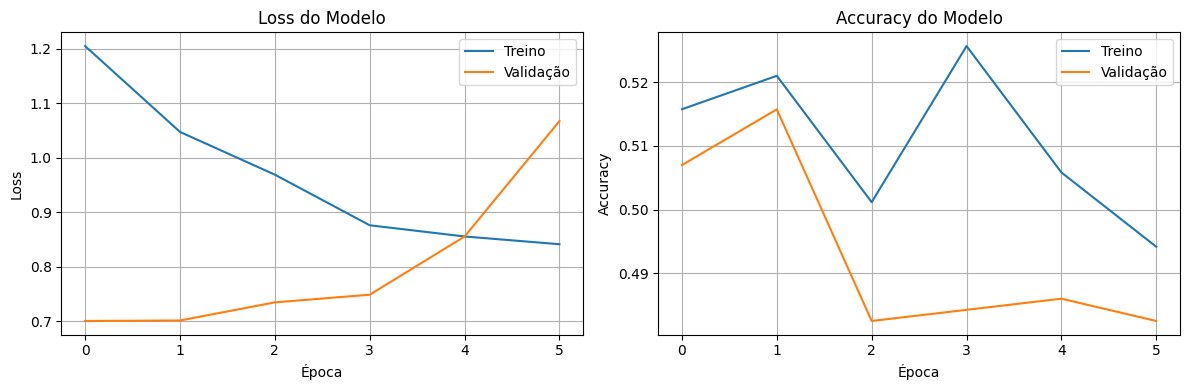

In [6]:
# Visualizar histórico de treinamento
plot_training_history(history)


## 3. Avaliação do Modelo

Avaliamos o modelo no conjunto de teste.


In [7]:
# Carregar melhor modelo (salvo pelo ModelCheckpoint)
best_model = keras.models.load_model(checkpoint_path)

# Avaliar modelo
print("Avaliação no Conjunto de Teste:")
print("=" * 60)
metrics = evaluate_model(best_model, test_gen, class_names, verbose=True)


Avaliação no Conjunto de Teste:
Métricas de Avaliação
Loss: 0.7037
Accuracy: 0.4983

Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.54      0.48      0.51       324
   MALIGNANT       0.46      0.53      0.49       276

    accuracy                           0.50       600
   macro avg       0.50      0.50      0.50       600
weighted avg       0.50      0.50      0.50       600


ROC AUC por classe:
  BENIGN: 0.4930
  MALIGNANT: 0.4930


### 3.1 Matriz de Confusão


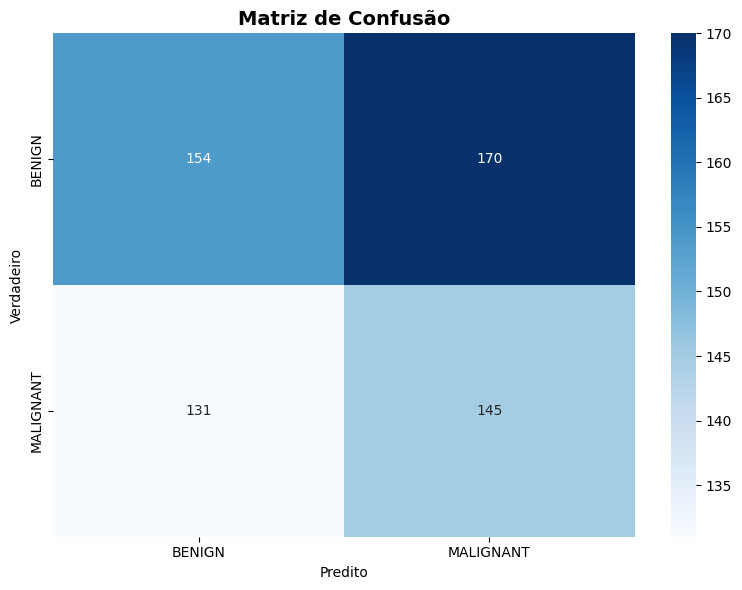

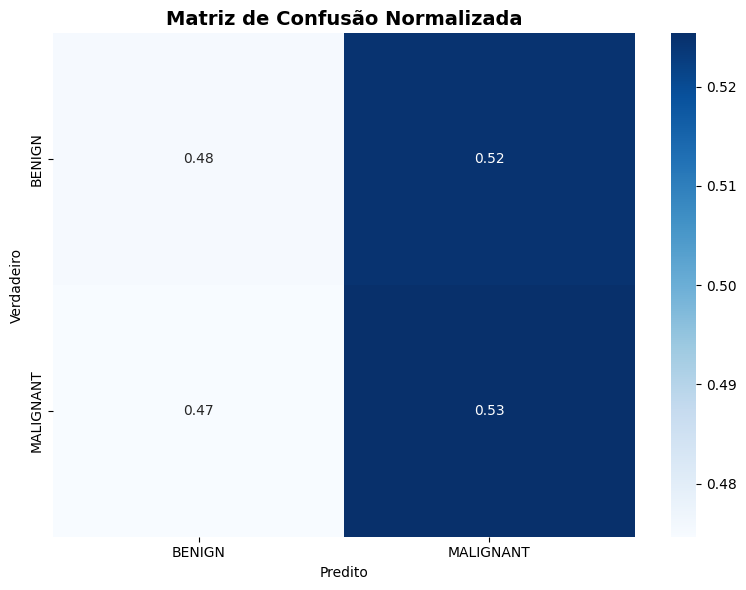

In [8]:
# Obter predições para matriz de confusão
y_pred_proba = best_model.predict(test_gen, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# Obter labels verdadeiros
y_true = []
for i in range(len(test_gen)):
    _, y_batch = test_gen[i]
    y_true.extend(np.argmax(y_batch, axis=1))
y_true = np.array(y_true)

# Plotar matriz de confusão
plot_confusion_matrix(y_true, y_pred, class_names, normalize=False)
plot_confusion_matrix(y_true, y_pred, class_names, normalize=True)


### 3.2 Curva ROC


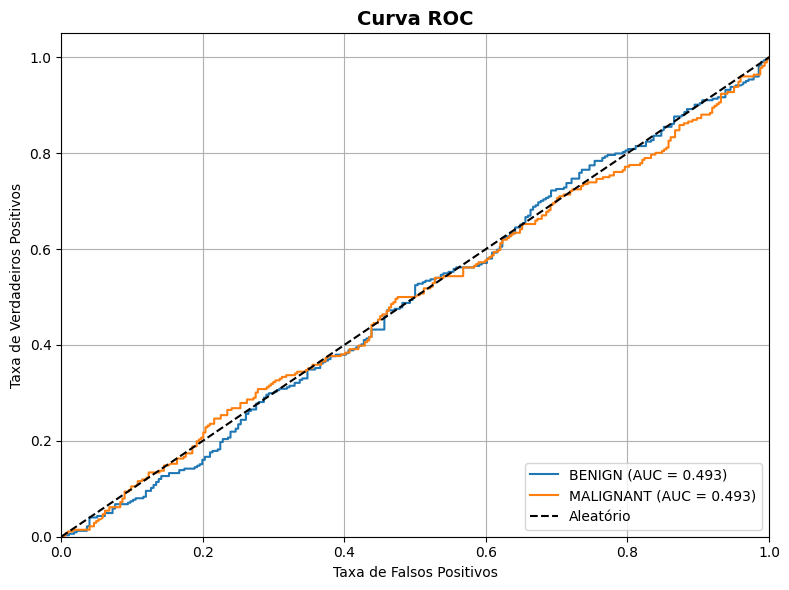

In [9]:
# Plotar curva ROC
y_true_onehot = keras.utils.to_categorical(y_true, len(class_names))
plot_roc_curve(y_true_onehot, y_pred_proba, class_names)


### 3.3 Visualização de Predições


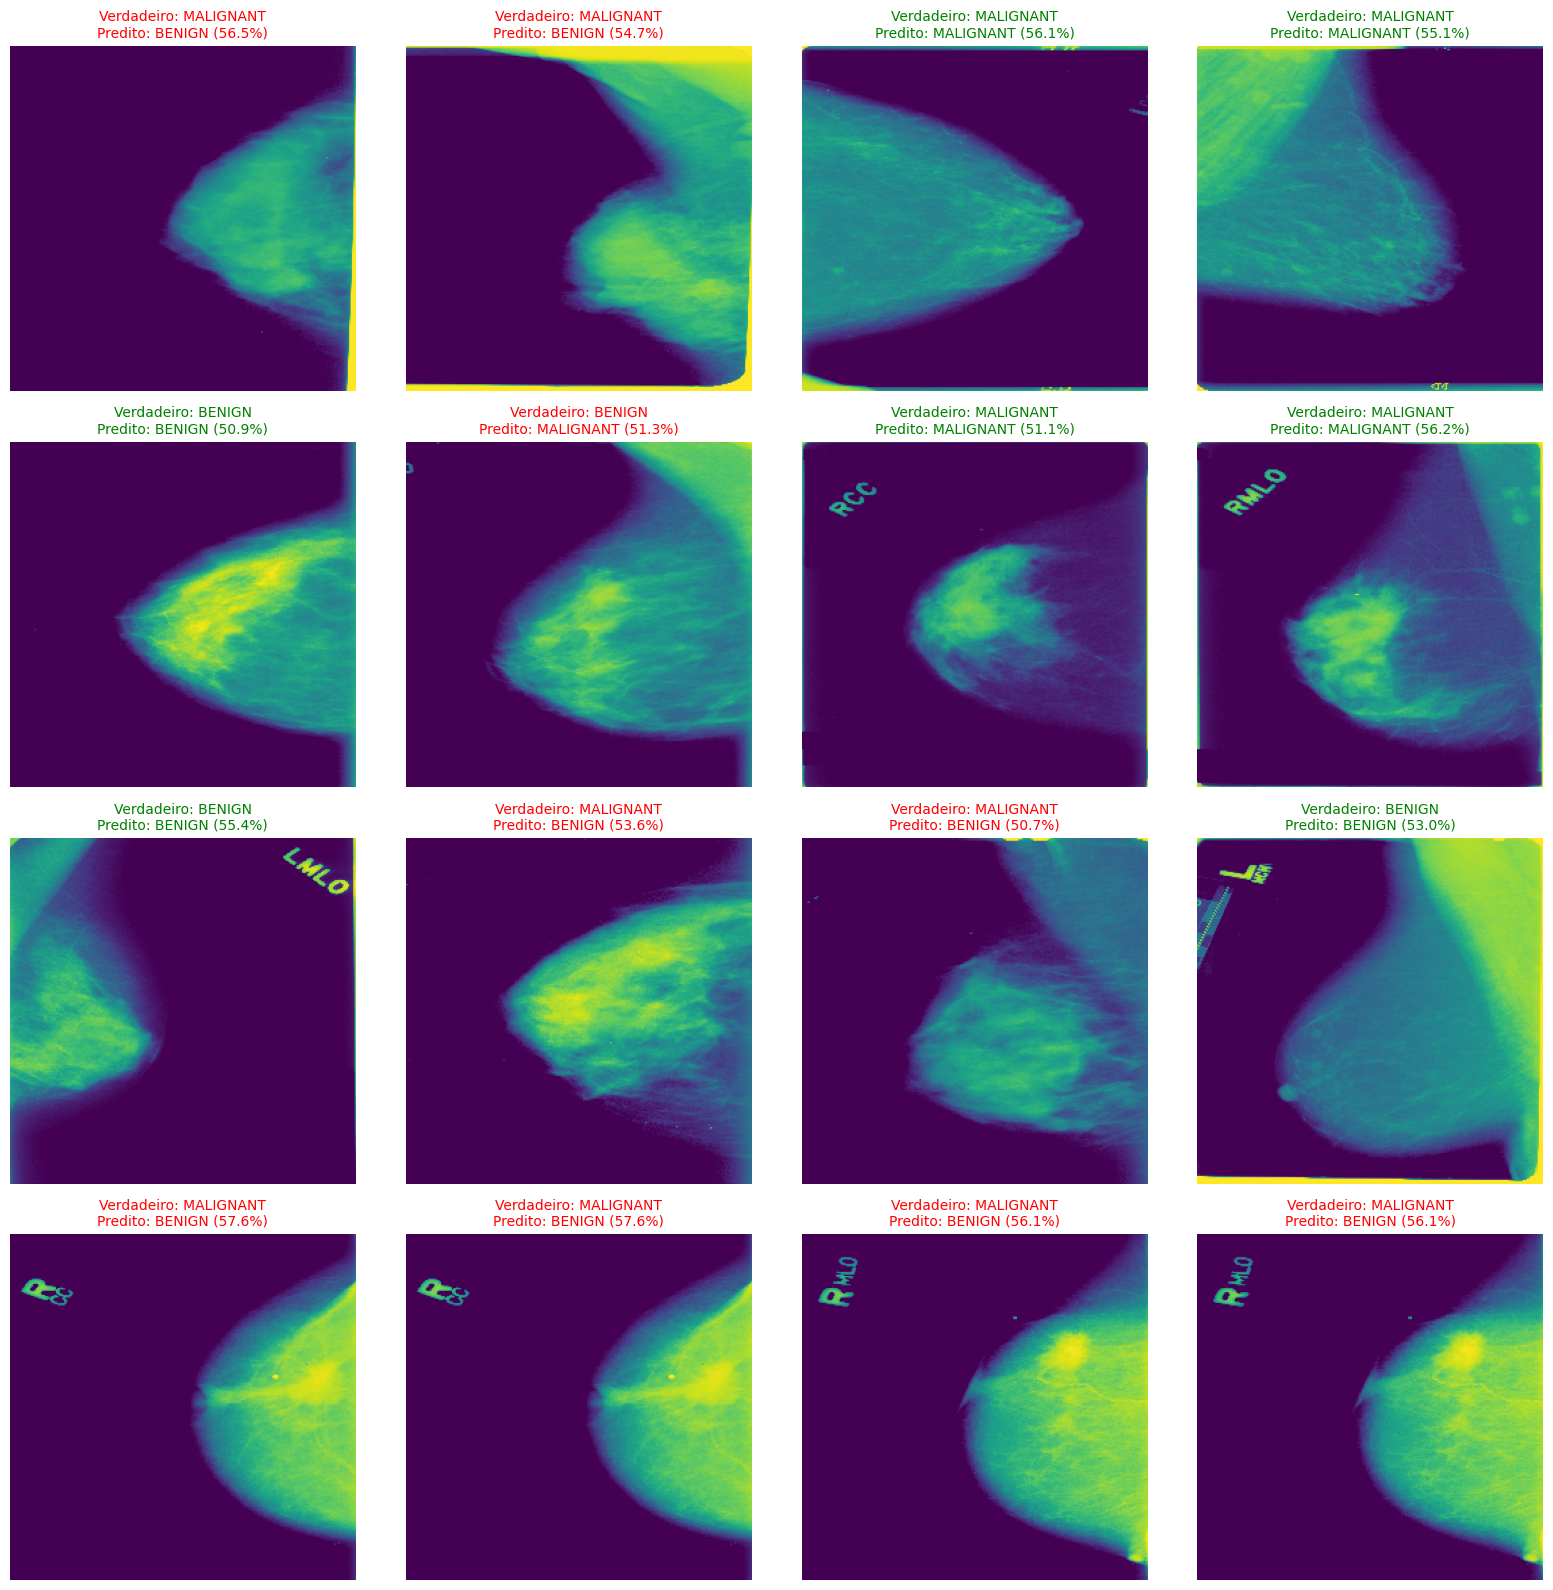

In [10]:
# Visualizar predições
visualize_predictions(best_model, test_gen, class_names, num_samples=16)


## 4. Interpretabilidade com Grad-CAM



Grad-CAM para amostra de classe 'BENIGN':


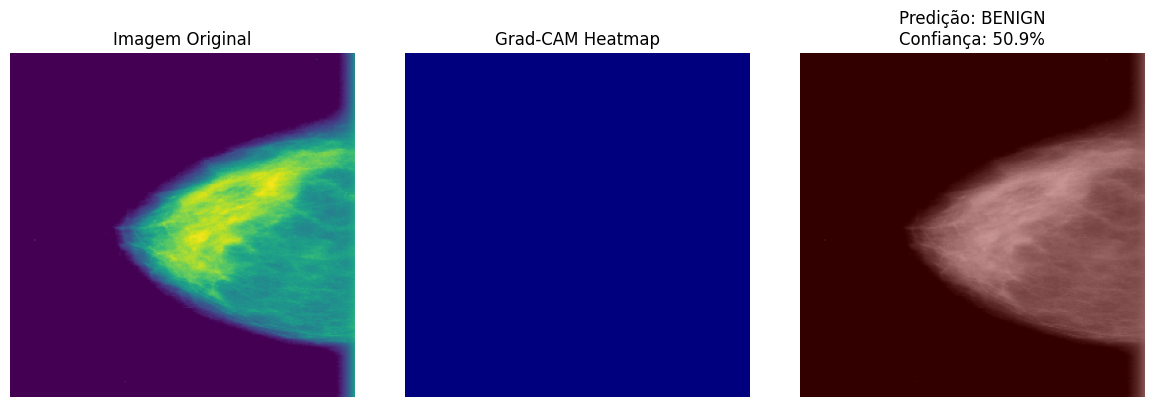


Grad-CAM para amostra de classe 'MALIGNANT':


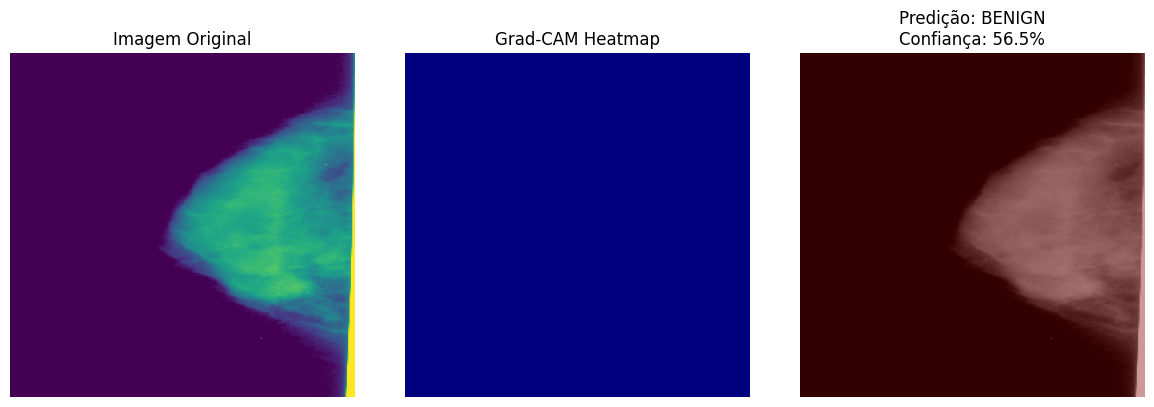

In [11]:
# Selecionar algumas amostras para análise Grad-CAM
x_batch, y_batch = test_gen[0]

# Selecionar amostras de cada classe
for class_idx, class_name in enumerate(class_names):
    class_samples = np.where(np.argmax(y_batch, axis=1) == class_idx)[0]
    if len(class_samples) > 0:
        sample_idx = class_samples[0]
        img_array = x_batch[sample_idx]
        
        print(f"\nGrad-CAM para amostra de classe '{class_name}':")
        plot_grad_cam(best_model, img_array, class_names)


## 5. Persistência do Modelo


In [12]:
# Verificar se o modelo foi salvo
import os
if os.path.exists(checkpoint_path):
    print(f"Modelo salvo com sucesso em: {checkpoint_path}")
    
    # Carregar e validar modelo salvo
    loaded_model = keras.models.load_model(checkpoint_path)
    
    # Fazer uma predição de teste
    test_batch_x, test_batch_y = test_gen[0]
    test_pred = loaded_model.predict(test_batch_x[:1], verbose=0)
    test_true = np.argmax(test_batch_y[0])
    test_pred_class = np.argmax(test_pred[0])
    
    print(f"\nValidação do modelo carregado:")
    print(f"  Imagem de teste - Classe verdadeira: {class_names[test_true]}")
    print(f"  Predição: {class_names[test_pred_class]} (confiança: {test_pred[0][test_pred_class]*100:.2f}%)")
    print("\nModelo validado com sucesso!")
else:
    print(f"Modelo não encontrado em: {checkpoint_path}")
    print("Salvando modelo manualmente...")
    best_model.save(checkpoint_path)
    print("Modelo salvo!")


Modelo salvo com sucesso em: ../models/breast_cancer_cnn_model.h5



Validação do modelo carregado:
  Imagem de teste - Classe verdadeira: MALIGNANT
  Predição: BENIGN (confiança: 56.45%)

Modelo validado com sucesso!
